In [188]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from scipy.interpolate import SmoothBivariateSpline
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded

In [189]:
def get_option_chain(symbol, num_dates, num_strikes): # You can define how many implied volatility data points to be used for implied volatility surface
    ticker = yf.Ticker(symbol)
    spot_price = ticker.history(period="1d")['Close'].iloc[-1] # Use to filter out Deep ITM and OTM options, preventing issues in calculating local volatility (d^2C/dK^2 -> 0)
    today = pd.Timestamp.today() # Use to calculate T
    
    # Select the most nearest expiration dates, which are the most active markets, so the prices are valid
    expiration = ticker.options[:num_dates]
    options = []
    
    for date in expiration:
        
        calls = ticker.option_chain(date).calls
        
        # Prevent recording expired options
        date = pd.to_datetime(date)
        T = (date - today).days / 252 # Assume 252 trading days
        if T <= 0:
            continue
        
        # Select the most at the money options, which are often the most liquid options, to construct the surface
        calls['ATM'] = abs(calls['strike'] - spot_price)
        nearest_calls = calls.nsmallest(num_strikes, 'ATM').copy()
        
        # Record expiration as percentage of a year 
        nearest_calls['T'] = T 
        options.append(nearest_calls[['T', 'impliedVolatility', 'strike', 'lastPrice']])
    
    filtered_chain = pd.concat(options).reset_index(drop=True)
    # imp_vol_df = filtered_chain.pivot(index='T', columns='strike', values='impliedVolatility')
    # market_price_df = filtered_chain.pivot(index='T', columns='strike', values='lastPrice')
    
    return filtered_chain, spot_price#, imp_vol_df, market_price_df

In [190]:
def bsm_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2)* T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return price

def local_volatility(filtered_chain, spot_price, r): 
    # Construct IV surface 
    K = filtered_chain['strike'].to_numpy()
    T = filtered_chain['T'].to_numpy()
    iv = filtered_chain['impliedVolatility'].to_numpy()
    iv_spline = SmoothBivariateSpline(K, T, iv, s=0.1)
    
    # Construct Call surface
    sigma = iv_spline.ev(K, T)
    # print('sigma:', sigma)
    call_prices = bsm_call_price(spot_price, K, T, r, sigma)
    # print('call:', call_prices)
    call_spline = SmoothBivariateSpline(K, T, call_prices, s=0.1)
    
    # Calculate local volatility
    dC_dT = call_spline.ev(K, T, dx=0, dy=1)
    d2C_dK2 = call_spline.ev(K, T, dx=2, dy=0)
    # print("dC_dT:", dC_dT[:10])
    # print("d2C_dK2:", d2C_dK2[:10])
    sigma_sq = dC_dT / (0.5 * K**2 * d2C_dK2)
    sigma_loc = np.sqrt(sigma_sq)
    sigma_spline = SmoothBivariateSpline(K, T, sigma_sq, s=1)

    return sigma_loc, sigma_spline

In [191]:
option_info = get_option_chain('AAPL',10,10)
sigma_loc, lv_spline = local_volatility(option_info[0],option_info[1],0.02) # Assume 0.02 risk-free rate

C:\Users\insan\AppData\Local\Temp\ipykernel_18200\3456590030.py:27: RuntimeWarning: invalid value encountered in sqrt
  sigma_loc = np.sqrt(sigma_sq)


c:\Users\insan\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\tri\_triangulation.py:181: RuntimeWarning: invalid value encountered in cast
  triangles = np.asarray(triangles, dtype=np.int32)


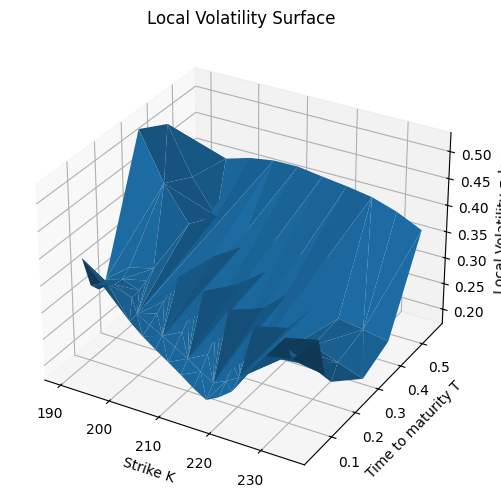

In [192]:
# The spikes on the surface imply unstable second derivatives. To resolve this, further techniques like SV models are required
# Overall, the model captures the volatility smile/skew structure

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(option_info[0]['strike'].to_numpy(), option_info[0]['T'].to_numpy(), sigma_loc, linewidth=0.2, antialiased=True)
ax.set_xlabel("Strike K")
ax.set_ylabel("Time to maturity T")
ax.set_zlabel("Local Volatility σ_loc")
plt.title("Local Volatility Surface")
plt.show()

In [ ]:
# Pricing for single option with specific K and T
def Crank_Nicolson_Pricing(spot_price, T, K, r, sigma_func, n_x=200, n_t=200, risk=0.5):  # n_x: steps for log S, n_t: steps for time
    # Set up grid
    x_min = np.log(risk * spot_price)
    x_max = np.log((risk**-1) * spot_price)
    dx = (x_max - x_min)/(n_x -1)
    dt = T / n_t
    x = np.linspace(x_min, x_max, n_x)  
    t = np.linspace(0, T, n_t) 
    S = np.exp(x)
     
    # Initialize step-wise backwards solution
    u = np.maximum(S - K, 0)
     
    left_boundary = np.maximum(np.exp(x_min) - K * np.exp(-r * (T - t)), 0)
    right_boundary = np.maximum(np.exp(x_max) - K * np.exp(-r * (T - t)), 0)
    
    # Solve diagonal entries
    sigma_sq = sigma_func.ev(K,T)  # local volatility square for option with settlement K and maturity T
    alpha = 0.5 * sigma_sq / (dx ** 2) + (r - 0.5 * sigma_sq) / (2 * dx) # lower
    beta = -r - sigma_sq / (dx ** 2) # diagonal
    theta = 0.5 * sigma_sq / (dx ** 2) - (r - 0.5 * sigma_sq) / (2 * dx) # upper
    
    # Define L operator and its corresponding matrix, then derive matrix A & B in Crank Nicolson algorithm
    dt_L = (np.diag(beta * np.ones(n_x -2)) +  # diagonal
            np.diag(theta * np.ones(n_x -3), k=1) + # upper
            np.diag(alpha * np.ones(n_x -3), k=-1)) * dt/2 # lower
    A = np.diag(np.ones(n_x -2)) + dt_L
    B = A - 2 * dt_L
    ab_A = to_banded(A)

    # Compute u^n from Au^n = Bu^{n+1} + b 
    for index in range(len(t)):
        current = len(t) - 1 - index # index for u^{n+1}
        previous = current - 1 # # index for u^{n}
        b_0 = - dt/2 * alpha * (left_boundary[current] + left_boundary[previous]) # the boundary value of the 1st row 
        b_n = - dt/2 * theta * (right_boundary[current] + right_boundary[previous]) # the boundary value of the last row 
        b = np.zeros(n_x-2)
        b[0], b[-1] = b_0, b_n # construct boundary value array
        RHS = B @ u[1:len(u)-1] + b
        u_inner = solve_banded((1,1), ab_A, RHS)
        u = np.concatenate(([left_boundary[previous]], u_inner, [right_boundary[previous]]))
        
    return u[int(0.5 * (n_x - 1))] # Option value that corresponds to the current stock price

# Transform A to solver required format
def to_banded(A):
    n = A.shape[0]
    ab = np.zeros((3, n))
    ab[0, 1:] = np.diag(A, k=1)
    ab[1, :]  = np.diag(A, k=0)
    ab[2, :-1]= np.diag(A, k=-1)
    return ab
      

In [250]:
print('Available options maturity (in Years):', option_info[0]['T'].unique())
print('Available options strikes:',option_info[0]['strike'].unique())
print('Current stock price', option_info[1])

Available options maturity (in Years): [0.02777778 0.05555556 0.08333333 0.11111111 0.13888889 0.16666667
 0.30555556 0.41666667 0.55555556]
Available options strikes: [212.5 215.  210.  217.5 207.5 220.  205.  222.5 202.5 225.  200.  230.
 195.  235.  190. ]
Current stock price 213.5500030517578


In [251]:
Crank_Nicolson_Pricing(213.5500030517578, option_info[0]['T'].unique()[0], 220, 0.02, lv_spline)

1.0068390345049196e+35

In [252]:
option_info[0][ (option_info[0]['T'] == option_info[0]['T'].unique()[0]) & (option_info[0]['strike']==220)]

,T,impliedVolatility,strike,lastPrice
5,0.027778,0.202645,220.0,0.65


In [253]:
Crank_Nicolson_Pricing(213.5500030517578, option_info[0]['T'].unique()[1], 220, 0.02, lv_spline)

1.3542413142723154e+90

In [254]:
option_info[0][ (option_info[0]['T'] == option_info[0]['T'].unique()[1]) & (option_info[0]['strike']==220)]

,T,impliedVolatility,strike,lastPrice
15,0.055556,0.217171,220.0,1.47
